## Origen de Datos

In [78]:
# Cargar librerias 
import pandas as pd 
import numpy as np
import scipy
import pyodbc
import random
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

import sklearn
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')


In [4]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [76]:

#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT  ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,AREA_EDUCATIVA,NIVEL_EDUCATIVO,LINEA_PRIORIZADA FROM st.[SI_acfm.maestro.oferta_formativa]"""
oferta_formativa_df = pd.read_sql_query(query1,conn)


## interacciones del usuario con sifods
query2 = """SELECT ID_OFERTA_FORMATIVA,DNI_DOCENTE,PREFERENCIA,VISTAS,CALIFICACIONES,CALIFICACION,COMPARTIR,COMENTARIOS FROM st.[SI_acfm.transaccional.oferta_formativa_accion]"""
acciones_df = pd.read_sql_query(query2,conn)


#Cerrar la conexion
conn.close()

C:\Users\pbenites\AppData\Local\Temp\ipykernel_9052\2918146879.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  oferta_formativa_df = pd.read_sql_query(query1,conn)
C:\Users\pbenites\AppData\Local\Temp\ipykernel_9052\2918146879.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  acciones_df = pd.read_sql_query(query2,conn)


In [79]:
# #Carga de datos repositorio local
# oferta_formativa_df = pd.read_csv("D:/difods2023_home/data/oferta_formativa.csv",sep=";")
# acciones_df = pd.read_excel("D:/difods2023_home/data/acciones.xlsx",dtype={'DNI_DOCENTE': np.str})


## Manipulación de datos

In [80]:
oferta_formativa_df = oferta_formativa_df.apply(lambda x: x.astype(str).str.upper())
oferta_formativa_df.head()


,ID,NOMBRE,PROPOSITO,PUBLICO_OBJETIVO,AREA_EDUCATIVA,NIVEL_EDUCATIVO,LINEA_PRIORIZADA
0,1,ACTUANDO FRENTE A LA SEGUNDA OLA DEL COVID-19,.,DOCENTES,729,1152,787
1,2,ANALIZANDO EVIDENCIAS PARA MEJORAS: CIUDADANÍA...,.,DOCENTES,729,1152,787
2,3,ANALIZANDO EVIDENCIAS PARA MEJORAS: COMPRENSIÓ...,.,DOCENTES,729,0,787
3,4,ANALIZANDO EVIDENCIAS PARA MEJORAS: INDAGACIÓN...,.,DOCENTES,729,1152,787
4,5,ANALIZANDO EVIDENCIAS PARA MEJORAS: RESOLUCIÓN...,.,DOCENTES,729,0,787


In [81]:
# Descripciones de cursos similares 
cursos_similares = oferta_formativa_df.groupby('NOMBRE')['NOMBRE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
print('# Cursos de la oferta formativa con más de dos registros: %d' %len(cursos_similares[cursos_similares['CONTEO']>1]))


# Cusrsos de la oferta formativa con más de dos registros: 13


# EDA

In [182]:
#Cursos mas populares
rating_oferta_formativa = acciones_df[['ID_OFERTA_FORMATIVA','VISTAS']].groupby('ID_OFERTA_FORMATIVA').mean().reset_index().sort_values('VISTAS',ascending=False)
rating_oferta_formativa['ID_OFERTA_FORMATIVA'] = rating_oferta_formativa['ID_OFERTA_FORMATIVA'].astype('str')
rating_oferta_formativa_df = rating_oferta_formativa.merge(oferta_formativa_df, how='left',left_on='ID_OFERTA_FORMATIVA',right_on='ID')
rating_oferta_formativa_df[['NOMBRE','VISTAS']].head(5)




,NOMBRE,VISTAS
0,REGIÓN LAMBAYEQUE,9.25
1,CAMPUS FORMATIVO REGIÓN ICA,9.00
2,REGIÓN HUANCAVELICA,8.00
3,REGIÓN SAN MARTÍN,7.50
4,REGIÓN ICA,7.20


In [183]:
#Frecuencia de cursos mas populares
frecuencia_cursos = acciones_df['ID_OFERTA_FORMATIVA'].value_counts()
print(frecuencia_cursos)

243    26468
162    18309
197    12904
232    12096
196    10437
       ...  
151        1
159        1
52         1
50         1
75         1
Name: ID_OFERTA_FORMATIVA, Length: 205, dtype: int64


In [184]:
#Frecuencia de curso con mas de 100 interacciones
frecuencia_valida_cursos = frecuencia_cursos[frecuencia_cursos > 100].index
print(frecuencia_valida_cursos)

Int64Index([243, 162, 197, 232, 196, 231, 244, 199, 198, 208,
            ...
            136,  78,  33, 119,  32,  34, 118,  80,  29,  30],
           dtype='int64', length=102)


In [204]:
#Tomamos como referencia solo los cursos con frecuencia mas de 100
acciones_df_100 = acciones_df[acciones_df['ID_OFERTA_FORMATIVA'].isin(frecuencia_valida_cursos)]


rating_oferta_formativa_100 = acciones_df_100[['ID_OFERTA_FORMATIVA', 'VISTAS']].groupby('ID_OFERTA_FORMATIVA').mean().reset_index().sort_values('VISTAS', ascending=False)
rating_oferta_formativa_100['ID_OFERTA_FORMATIVA'] = rating_oferta_formativa_100['ID_OFERTA_FORMATIVA'].astype('str')
rating_oferta_formativa_df_100 = rating_oferta_formativa_100.merge(oferta_formativa_df, how='left', left_on='ID_OFERTA_FORMATIVA', right_on='ID')
#rating de cursos con promedio de vistas e interracciones mayores a 100
rating_oferta_formativa_df_100[['ID','NOMBRE', 'VISTAS']].head(5)


,ID,NOMBRE,VISTAS
0,243,PROGRAMA DE ACTUALIZACIÓN DOCENTE PARA EL INIC...,5.370372
1,232,USO PEDAGÓGICO DE MATERIALES EDUCATIVOS,4.990410
2,205,CONOCIMIENTOS PEDAGÓGICOS Y DISCIPLINARES PARA...,4.101765
3,231,ESTRATEGIAS PARA EL DESARROLLO DE UNA CONVIVEN...,3.921790
4,236,PROGRAMA DE ACTUALIZACIÓN DOCENTE PARA EL INIC...,3.784997


# Selección de Variables
Se reviso las columnas de:
- Preferencia : Indica un "me gusta" en el curso
- Vistas : Contador de ingresos a los cursos
- Calificaciones : Numero de calificaciones que se da aun curso 
- Calificación : Puntuacion que se le asigna a un curso (las estrellas de que van de 0 a 5 )
- Compartir : Contador de la opcion compartir ( se puede compartir por facebook,linkedin, whatsapp, pinterest y twiter )
- Comentarios : Comentarios sobre el curso 

Los sistemas de recomendación se enfrentan al problema conocido como "arranque en frio", en el que es dificil proporcionar recomendaciones personalizadas a usuarios que no han consumido nada o muy poco
por ese motivo se excluiran a las personas con 0 vistas y con acciones en un solo curso

In [281]:
#Preferencia 
Porcentaje_preferencia=round((len(acciones_df[acciones_df['PREFERENCIA'] == 1]) / len(acciones_df) )* 100,1)
Porcentaje_vistas = round((len(acciones_df[acciones_df['VISTAS'] > 1]) / len(acciones_df)) * 100,1)
Porcentaje_calificaciones = round((len(acciones_df[acciones_df['CALIFICACIONES'] > 1]) / len(acciones_df)) * 100,1)
Porcentaje_califacion = round((len(acciones_df[acciones_df['CALIFICACION'] >0 ]) / len(acciones_df)) * 100,1)
Porcentaje_compartir = round((len(acciones_df[acciones_df['COMPARTIR'] >0 ]) / len(acciones_df)) * 100,1)
Porcentaje_comentarios = round((len(acciones_df[acciones_df['COMENTARIOS'] >0 ]) / len(acciones_df)) * 100,1)

print('Porcentaje de datos en la variable PREFERENCIA : ' + str(Porcentaje_preferencia) + '%')
print('Porcentaje de datos en la variable VISTAS : ' + str(Porcentaje_vistas) + '%')
print('Porcentaje de datos en la variable CALIFICACIONES : ' + str(Porcentaje_calificaciones) + '%')
print('Porcentaje de datos en la variable CALIFICACION : ' + str(Porcentaje_califacion) + '%')
print('Porcentaje de datos en la variable COMPARTIR : ' + str(Porcentaje_compartir) + '%')
print('Porcentaje de datos en la variable COMENTARIOS : ' + str(Porcentaje_comentarios) + '%')

Porcentaje de datos en la variable PREFERENCIA : 2.4%
Porcentaje de datos en la variable VISTAS : 82.4%
Porcentaje de datos en la variable CALIFICACIONES : 0.3%
Porcentaje de datos en la variable CALIFICACION : 0.9%
Porcentaje de datos en la variable COMPARTIR : 0.0%
Porcentaje de datos en la variable COMENTARIOS : 0.0%


In [82]:
acciones_df = acciones_df[acciones_df['VISTAS']>0]

In [83]:
usuario_interaccion_count = acciones_df.groupby(['DNI_DOCENTE', 'ID_OFERTA_FORMATIVA']).size().groupby('DNI_DOCENTE').size()
print('# usuarios: %d' % len(usuario_interaccion_count))
usuario_considerado = usuario_interaccion_count[usuario_interaccion_count > 1].reset_index()[['DNI_DOCENTE']]
print('# usuarios con mas de 1 accion:  %d' % len(usuario_considerado)) 

# usuarios: 91394
# usuarios con mas de 1 accion:  47168


In [85]:
print('# de  acciones %d' % len(acciones_df))
acciones_seleccionadas = acciones_df.merge(usuario_considerado,
                                        how = 'right',
                                        left_on = 'DNI_DOCENTE',
                                        right_on = 'DNI_DOCENTE')
print('# de acciones de usuarios seleccionados : %d' %len(acciones_seleccionadas))

# de  acciones 230499
# de acciones de usuarios seleccionados : 186160


In [86]:
#Seleccionamos  las columnas de interes del dataframe acciones_seleccionadas
acciones_full_df=acciones_seleccionadas[['ID_OFERTA_FORMATIVA','DNI_DOCENTE','VISTAS']]
acciones_full_df.head()

,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS
0,232,00002741,26
1,196,00002741,2
2,242,00002741,9
3,198,00002741,1
4,85,00006009,1


In [88]:
scaler=MinMaxScaler()
acciones_full_df['CALIFICACION_TRANSFORMADO']=scaler.fit_transform(acciones_full_df[['VISTAS']])

In [89]:
acciones_full_df


,ID_OFERTA_FORMATIVA,DNI_DOCENTE,VISTAS,CALIFICACION_TRANSFORMADO
0,232,00002741,26,0.146199
1,196,00002741,2,0.005848
2,242,00002741,9,0.046784
3,198,00002741,1,0.000000
4,85,00006009,1,0.000000
...,...,...,...,...
186155,84,99999999,9,0.046784
186156,83,99999999,4,0.017544
186157,82,99999999,1,0.000000
186158,78,99999999,5,0.023392


# Modelado

In [90]:
print('# de interacciones: %d' % len(acciones_df))
registros_duplicados = acciones_full_df.groupby(['DNI_DOCENTE', 'ID_OFERTA_FORMATIVA'])['DNI_DOCENTE'].count().to_frame('CONT').reset_index().sort_values('CONT', ascending=False)
registros_duplicados = registros_duplicados[registros_duplicados['CONT']==1]
acciones_full_valido_df = acciones_full_df.merge(registros_duplicados, how='right' , left_on=['DNI_DOCENTE','ID_OFERTA_FORMATIVA'],right_on=['DNI_DOCENTE','ID_OFERTA_FORMATIVA'])
print('# de interacciones %d' %len(acciones_full_valido_df))

# de interacciones: 230499
# de interacciones 184296


In [91]:
acciones_entrenamiento_df, acciones_prueba_df = train_test_split(acciones_full_valido_df,
                                                            #stratify=acciones_full_df['DNI_DOCENTE'],
                                                            test_size=0.20,
                                                            random_state=42)

print('# acciones en el dataset entrenamiento: %d' %len(acciones_entrenamiento_df))
print('# acciones en el dataset prueba: %d' %len(acciones_prueba_df))

# acciones en el dataset entrenamiento: 147436
# acciones en el dataset prueba: 36860


In [92]:
#Creación de una tabla dinámica dispersa con usuarios en filas y elementos en columnas
usuario_item_pivot_matrix_df = acciones_entrenamiento_df.pivot(index='DNI_DOCENTE',
                                                                columns='ID_OFERTA_FORMATIVA',
                                                                values='CALIFICACION_TRANSFORMADO')

usuario_item_pivot_matrix_df.head(10)


ID_OFERTA_FORMATIVA,1,2,3,4,5,6,7,8,9,10,...,237,238,239,240,241,242,243,244,245,248
DNI_DOCENTE,,,,,,,,,,,,,,,,,,,,,
00002741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.046784,NaN,NaN,NaN,NaN
00006009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017544,NaN,0.005848,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00006226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011696,NaN,NaN
000073850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00008538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00010885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00011708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.011696,NaN,NaN,0.046784,0.023392,NaN,NaN
00012732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.005848,NaN,NaN,NaN,NaN,0.011696,NaN,NaN,NaN


In [93]:
# Calculando matrix sparsity
sparsity_count = usuario_item_pivot_matrix_df.isnull().values.sum()
# Contar todas las celdas
full_cont = usuario_item_pivot_matrix_df.size
# Numero de escazes del dataset
sparsity = round(sparsity_count / full_cont, 3)
print('El dataset tiene una escasez de : ' + str(sparsity*100) + '%')


El dataset tiene una escasez de : 98.4%


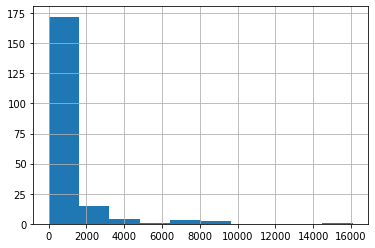

In [94]:
# Contar las celdas ocupadas por columna
count_celdas_ocupadas = usuario_item_pivot_matrix_df.notnull().sum()
# Ordenar el resultado de mayot a menor
sorted_count_celdas_ocupadas = count_celdas_ocupadas.sort_values()
# Plot Histograma
sorted_count_celdas_ocupadas.hist()
plt.show()


## Descomposión de valores singulares (SVD)

In [95]:
# Obtener la valoración media de cada usuario
avg_rating = usuario_item_pivot_matrix_df.mean(axis=1)
# Centrar las valoraciones de los usuarios entorno a 0
df_pivot_centered = usuario_item_pivot_matrix_df.sub(avg_rating, axis=0)
# Rellenar los datos que faltan con 0
df_pivot_centered.fillna(0, inplace=True)
# Comprobar la matriz centrada
print(df_pivot_centered.mean(axis=1))


DNI_DOCENTE
00002741     0.000000e+00
00006009     0.000000e+00
00006226     0.000000e+00
000073850    0.000000e+00
00007462     0.000000e+00
                 ...     
80685802     0.000000e+00
80685932    -1.051348e-19
80688103     0.000000e+00
99999998     0.000000e+00
99999999     0.000000e+00
Length: 46327, dtype: float64


In [96]:
# Descomponer la Matrix
U, sigma, Vt = svds(df_pivot_centered)
# Converitir el sigma en la diagonal de la matriz
sigma = np.diag(sigma)


In [97]:
# Producto de puntos
U_sigma = np.dot(U, sigma)
# Producto de puntos del resultado
U_sigma_Vt = np.dot(U_sigma, Vt)
# Las medias de las filas contenidas
Calificaciones_descentradas = U_sigma_Vt + avg_rating.values.reshape(-1, 1)

calc_pred_df = pd.DataFrame(Calificaciones_descentradas,
                            index=usuario_item_pivot_matrix_df.index,
                            columns=usuario_item_pivot_matrix_df.columns)

print(calc_pred_df)


ID_OFERTA_FORMATIVA       1         2         3         4         5    \
DNI_DOCENTE                                                             
00002741             0.017554  0.017545  0.017543  0.017544  0.017545   
00006009             0.007797  0.007797  0.007797  0.007797  0.007797   
00006226             0.011696  0.011696  0.011696  0.011696  0.011696   
000073850            0.004873  0.004873  0.004873  0.004873  0.004873   
00007462             0.005848  0.005848  0.005848  0.005848  0.005848   
...                       ...       ...       ...       ...       ...   
80685802             0.007784  0.007795  0.007774  0.007792  0.007794   
80685932             0.019680  0.019669  0.019635  0.019673  0.019670   
80688103             0.002928  0.002924  0.002924  0.002924  0.002924   
99999998             0.005014  0.005013  0.005014  0.005013  0.005013   
99999999             0.026733  0.026733  0.026733  0.026733  0.026733   

ID_OFERTA_FORMATIVA       6         7         8   

In [98]:
# Ordenar la valoración del usuario 5 de mayor a menor
user_100_ratings = calc_pred_df.iloc[0, :].sort_values(ascending=False)
print(user_100_ratings.head(10))


ID_OFERTA_FORMATIVA
197    0.019196
244    0.018893
231    0.018629
162    0.018287
208    0.018072
198    0.018057
206    0.018048
234    0.018021
205    0.017932
232    0.017910
Name: 00002741, dtype: float64


# Evaluación

In [99]:
# Comparar los metodos de recomendación
# Extraer los valores verdaderos para comparar las predicciones
actual_valor = usuario_item_pivot_matrix_df.iloc[:20, :100].values
predict_values = calc_pred_df.iloc[:20,:100].values 
mask = ~np.isnan(actual_valor)
print(mean_squared_error(actual_valor[mask], predict_values[mask],squared=False))

0.033522626704341134


# Predicción

In [100]:
calc_pred_df = pd.DataFrame(calc_pred_df)
calc_pred_df = calc_pred_df.reset_index()
calc_pred_df.head()


ID_OFERTA_FORMATIVA,DNI_DOCENTE,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,248
0,00002741,0.017554,0.017545,0.017543,0.017544,0.017545,0.017559,0.017541,0.017528,0.017544,...,0.017579,0.017624,0.017714,0.017540,0.017567,0.017640,0.017680,0.018893,0.017544,0.017544
1,00006009,0.007797,0.007797,0.007797,0.007797,0.007797,0.007796,0.007796,0.007797,0.007797,...,0.007800,0.007793,0.007793,0.007790,0.007794,0.007796,0.007748,0.007722,0.007797,0.007797
2,00006226,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,...,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696,0.011696
3,000073850,0.004873,0.004873,0.004873,0.004873,0.004873,0.004873,0.004873,0.004873,0.004873,...,0.004872,0.004872,0.004872,0.004871,0.004872,0.004872,0.004888,0.004861,0.004873,0.004873
4,00007462,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,...,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848,0.005848


In [127]:
# Obtener dataset de resultados
df_f = calc_pred_df.melt(id_vars='DNI_DOCENTE', var_name='ID_OFERTA_FORMATIVA', value_name='CALIFICACION_TRANSFORMADO')
df_f['CALIFICACION_TRANSFORMADO'] = np.round(df_f['CALIFICACION_TRANSFORMADO'], 5)
df_f.head(10)

,DNI_DOCENTE,ID_OFERTA_FORMATIVA,CALIFICACION_TRANSFORMADO
0,00002741,1,0.01755
1,00006009,1,0.00780
2,00006226,1,0.01170
3,000073850,1,0.00487
4,00007462,1,0.00585
5,00008538,1,0.00000
6,00010885,1,0.01754
7,00011708,1,0.02572
8,00012732,1,0.00877
9,00015535,1,0.04674


In [283]:
# Prueba con el docente de dni 00015535 
df_f[df_f['DNI_DOCENTE']== '00015535'].sort_values(by='CALIFICACION_TRANSFORMADO', ascending= False).head(5)

,DNI_DOCENTE,ID_OFERTA_FORMATIVA,CALIFICACION_TRANSFORMADO
8987447,00015535,243,0.16030
8477850,00015535,231,0.04942
5976192,00015535,162,0.04867
8524177,00015535,232,0.04864
6995386,00015535,197,0.04815
